# GEDI Data Access

This notebook contains a workflow for easily accessing GEDI elevation data. The product accessed could be used to co-locate with snow-on and snow-off DEMs to derive and validate snow depth.

This notebook requires the earthaccess Python package. It is also adapted from work by Tasha Snow and Zachary Fair at the 2024 NASA Earth Sciences Hackweek.

We start up `earthaccess` first, so that we are properly authenticated.

In [1]:
import earthaccess

# Authenticate for accessing NASA data
auth = earthaccess.login(strategy="netrc")

# If we are not authenticated
if not auth.authenticated:
    # Ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)

The `earthaccess` package requires several user inputs:
* `concept-id`: The concept ID of the dataset, as logged by EarthData.
* `bounding_box`: A tuple containing the lat/lon bounds (lon_min, lat_min, lon_max, lat_max)
* `temporal`: A tuple containing the temporal bounds, in string format (YYYY-MM-DD).
* `cloud_hosted`: If `True`, then prioritize cloud-based data.
* `count`: The maximum number of files for earthaccess to return.

Most of these inputs are self-explanatory, but finding the `concept-id` can be non-trivial for `earthaccess` users. As part of SnowPit, a catalog was made that matches NASA datasets with their corresponding concept IDs.

In [4]:
import pandas as pd

# Read earthaccess concept-id catalog
df = pd.read_csv("/home/jovyan/SnowPit/cloud_data_access_list.csv")
df = df.set_index('Dataset')

Note that the concept ID for GEDI is for the Level-2A (Elevation and Height Metrics) product, arguably the best product to derive snow depth with GEDI.

We can then access the GEDI data using the below cell. Note that this routine accesses the data directly through the cloud, rather than downloading it.

In [5]:
# User Input
bbox = (-10, 20, 10, 50)
date_range = ("1999-02", "2024-10")
cloud = True
numfiles = 10

# Create earthaccess query
results = earthaccess.search_data(
                concept_id = df.loc["GEDI"]["concept-id"],
                bounding_box = bbox,
                temporal = date_range,
                cloud_hosted = cloud,
                count = numfiles
)

We can now access the GEDI data from the results reasonably quickly through the cloud. Note that this routine loads a single data path from single file into Xarray - for multiple file/variable loading, either downloading the data (further below) or appending to a Pandas DataFrame will be more memory-efficient.

In [9]:
import xarray as xr

# Load elevation data from one of the beams
files = earthaccess.open(results)
ds = xr.open_dataset(files[1], group='/BEAM0001/', phony_dims='sort')

QUEUEING TASKS | :   0%|          | 0/10 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/10 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/10 [00:00<?, ?it/s]

In [12]:
ds

<xarray.Dataset> Size: 88MB
Dimensions:                       (phony_dim_35: 167319, phony_dim_36: 101)
Coordinates:
    delta_time                    (phony_dim_35) datetime64[ns] 1MB 2019-04-1...
    lat_highestreturn             (phony_dim_35) float64 1MB 0.1342 ... 51.82
    lat_lowestmode                (phony_dim_35) float64 1MB 0.1342 ... 51.82
    latitude_bin0_error           (phony_dim_35) float32 669kB 4.387e-05 ... ...
    lon_highestreturn             (phony_dim_35) float64 1MB -34.11 ... 50.27
    lon_lowestmode                (phony_dim_35) float64 1MB -34.11 ... 50.27
    longitude_bin0_error          (phony_dim_35) float32 669kB 3.194e-05 ... ...
Dimensions without coordinates: phony_dim_35, phony_dim_36
Data variables: (12/24)
    beam                          (phony_dim_35) uint16 335kB ...
    channel                       (phony_dim_35) uint8 167kB ...
    degrade_flag                  (phony_dim_35) uint8 167kB ...
    digital_elevation_model       (phony_dim_35) float32 669kB ...
    digital_elevation_model_srtm  (phony_dim_35) float32 669kB ...
    elev_highestreturn            (phony_dim_35) float32 669kB ...
    ...                            ...
    selected_mode_flag            (phony_dim_35) uint8 167kB ...
    sensitivity                   (phony_dim_35) float32 669kB ...
    shot_number                   (phony_dim_35) uint64 1MB ...
    solar_azimuth                 (phony_dim_35) float32 669kB ...
    solar_elevation               (phony_dim_35) float32 669kB ...
    surface_flag                  (phony_dim_35) uint8 167kB ...
Attributes:
    description:  Coverage beam

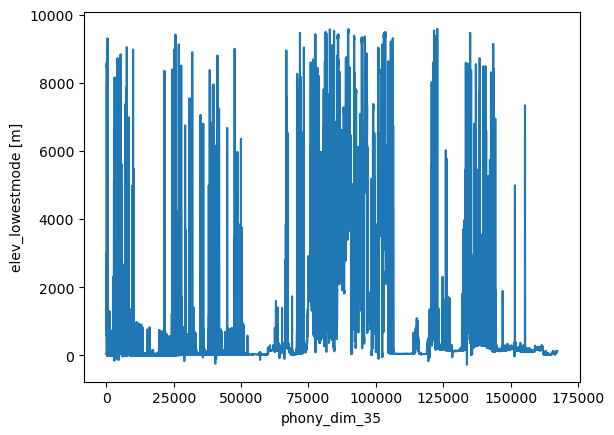

In [13]:
# Plot along-track GEDI elevation from the first beam
ds['elev_lowestmode'].plot()

If the data looks promising, then we can save the files from our query for continued analysis.

In [15]:
# Save GEDI files to specified directory
downloads = earthaccess.download(results, '/home/jovyan/SnowPit/tmp/')

## Using H5Coro to Access the Data

The above workflow is useful for a first-time user, though it may be a bit slow if one wishes to look at multiple files quickly. H5Coro is a new package that makes loading HDF-5 files much faster, which is otherwise somewhat clumsy in Python.

The H5Coro python package is needed for this next workflow.

In [19]:
# Most up-to-date version of H5Coro needed to take NSIDC credentials
%pip install -U h5coro

  Using cached h5coro-0.0.8-py3-none-any.whl.metadata (815 bytes)
Using cached h5coro-0.0.8-py3-none-any.whl (40 kB)
  Attempting uninstall: h5coro
    Found existing installation: h5coro 0.0.6
    Uninstalling h5coro-0.0.6:
      Successfully uninstalled h5coro-0.0.6
Note: you may need to restart the kernel to use updated packages.


In [18]:
from h5coro import h5coro, s3driver, webdriver

# Setup s3 credentials
s3_creds = auth.get_s3_credentials(daac="LPDAAC")

ImportError: cannot import name 'webdriver' from 'h5coro' (/srv/conda/envs/notebook/lib/python3.11/site-packages/h5coro/__init__.py)

We are going to read all of the queried GEDI files, specifically loading `lat_lowestmode` (latitude), `lon_lowestmode` (longitude), and `elev_lowestmode` (elevation) from the first beam.

In [17]:
df = pd.DataFrame()
# Loop through earthaccess files
for f in files:
    # Define h5coro object
    h5obj = h5coro.H5Coro(f.full_name[5:], 
                          s3driver.S3Driver, 
                          credentials=s3_creds)

    # Define variables of interest
    variables = ['/BEAM0001/elev_lowestmode',
                 '/BEAM0001/lat_lowestmode',
                 '/BEAM0001/lon_lowestmode']

    # Get variable paths from h5coro object
    promise = h5obj.readDatasets(variables, block=True, enableAttributes=False)
    var_paths = list(promise.keys())

    # Create DataFrame for current file
    tmp = pd.DataFrame(data={'lat': promise[var_paths[0]],
                             'lon': promise[var_paths[1]],
                             'height': promise[var_paths[2]]
                                }
                          )

    # Add data to main DataFrame
    df = pd.concat([df, tmp], ignore_index=True)

display(df)

NameError: name 's3driver' is not defined

Work is currently underway by the icepyx development team to allow for full reading of HDF-5 data, notably ICESat-2 and GEDI, with a combination of icepyx and H5Coro. Stay tuned!